In [1]:
import os
import sys
sys.path.append('/workspace/patchcore-inspection/src')
sys.path.append('/workspace/patchcore-inspection/')
from patchcore.datasets.monuseg import get_monuseg_images, MoNuSegDataset


In [2]:

input_path = "/mnt/dataset/MoNuSeg/"

data_dirs = {
    'train' : os.path.join(input_path, "patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images"),
    'test' : os.path.join(input_path, "patches_valid_inst_128x128_128x128/MoNuSegTestData/images"),
    'v1.3' : "/workspace/patchcore-inspection/monuseg/test/syn/v1.3*/samples",
}

images = {k : get_monuseg_images('', [v], subsample=None) for k, v in data_dirs.items()}

images['v1.3']


['/workspace/patchcore-inspection/monuseg/test/syn/v1.3_output_model_s1.6_050000/samples/TCGA-G9-6362-01Z-00-DX1_025.png',
 '/workspace/patchcore-inspection/monuseg/test/syn/v1.3_output_model_s1.6_050000/samples/TCGA-21-5784-01Z-00-DX1_045.png',
 '/workspace/patchcore-inspection/monuseg/test/syn/v1.3_output_model_s1.6_050000/samples/TCGA-AY-A8YK-01A-01-TS1_041.png',
 '/workspace/patchcore-inspection/monuseg/test/syn/v1.3_output_model_s1.6_050000/samples/TCGA-G9-6348-01Z-00-DX1_033.png',
 '/workspace/patchcore-inspection/monuseg/test/syn/v1.3_output_model_s1.6_050000/samples/TCGA-G9-6363-01Z-00-DX1_048.png',
 '/workspace/patchcore-inspection/monuseg/test/syn/v1.3_output_model_s1.6_050000/samples/TCGA-AR-A1AK-01Z-00-DX1_051.png',
 '/workspace/patchcore-inspection/monuseg/test/syn/v1.3_output_model_s1.6_050000/samples/TCGA-AY-A8YK-01A-01-TS1_048.png',
 '/workspace/patchcore-inspection/monuseg/test/syn/v1.3_output_model_s1.6_050000/samples/TCGA-AR-A1AS-01Z-00-DX1_027.png',
 '/workspace/pat

### Load features

In [3]:
from feature_extractor.utils import extract_features
import json, os
import numpy as np
import torch

# backbone = "medsam"
# backbone = "optimus_old"
# backbone = "resnet50"
backbone = "optimus"

feat_dirs = {
    'train' : os.path.join(input_path, f"patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images_feat_{backbone}.json"),
    'test' : os.path.join(input_path, f"patches_valid_inst_128x128_128x128/MoNuSegTestData/images_feat_{backbone}.json"),
    'v1.3' : os.path.join(input_path, f"out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.3_feat_{backbone}.json")
}


features_dict = {}

for k, v in feat_dirs.items():
    feat_path = v
    # feat_path = k + f"_feat_{backbone}.json"

    assert os.path.exists(feat_path), f"Path doesn't exist: {feat_path}"

    with open(feat_path, 'r') as f:
        feat_json = json.load(f)

        # print(feat_json.keys())

        opt_feat_flat = [feat_json[i] for i in images[k]]
        opt_feat_flat = np.array(list(opt_feat_flat))  

        print(feat_path, opt_feat_flat.shape)        

        features_dict[k] = opt_feat_flat





/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images_feat_optimus.json (2368, 1536)
/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images_feat_optimus.json (896, 1536)
/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.3_feat_optimus.json (8607, 1536)


In [5]:
train_feat = features_dict['train']
test_feat = features_dict['test']
syn_feat = features_dict['v1.3']


In [6]:
emb_transform = "umap"

if emb_transform == "ss":
    from sklearn.preprocessing import StandardScaler

    reducer = StandardScaler()
    scaled_train_features = reducer.fit_transform(train_features)

elif emb_transform == "umap":
    import umap
    reducer = umap.UMAP(
        # n_neighbors=30,
        # min_dist=0.0, 
        n_components= 3, 
        # random_state= 42,
    )
    

elif emb_transform == "pca":
    from sklearn.decomposition import PCA  # to apply PCA
    reducer = PCA(**emb_kwargs)

else:
    raise NotImplementedError()


In [7]:
scaled_train_features = reducer.fit_transform(train_feat)


In [8]:
scaled_test_features = reducer.transform(test_feat)
scaled_syn_features = reducer.transform(syn_feat)


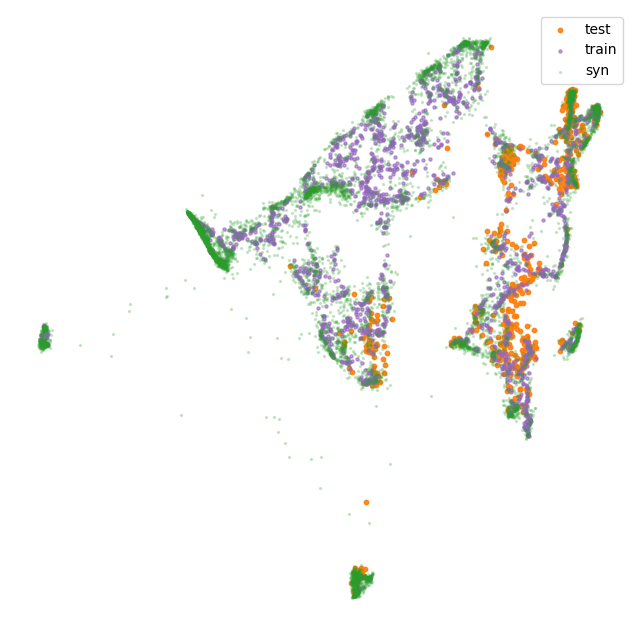

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(scaled_test_features[:, 0], scaled_test_features[:, 1], label='test', alpha=.9, s=10, color='C1')
plt.scatter(scaled_train_features[:, 0], scaled_train_features[:, 1], label='train', alpha=.6, s=5, color='C4')
plt.scatter(scaled_syn_features[:, 0], scaled_syn_features[:, 1], label='syn', alpha=.2, s=2, color='C2')

plt.axis('off')
plt.legend()
plt.show()

